In [1]:
%%capture capt
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install chess
!pip install tensorflow

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter
import time
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import chess

# Load data

In [3]:
%run S3.ipynb

In [4]:
#moves_df = pd.read_csv("../Data/moves_df.csv")
moves_df = open_csv("moves_df.csv")

In [5]:
moves_df

,game_index,moves,evaluation,fen,zobrist_key
0,0,e2e4,35,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,9384546495678726550
1,0,e7e5,48,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,595762792459712928
2,0,g1f3,111,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,15213300192948443293
3,0,b8c6,47,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,8704797333742910878
4,0,f1b5,52,r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/5N2/PPPP1PPP/R...,5409798013178080797
...,...,...,...,...,...
9023518,118318,a8c8,-6,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP1BP1/1P1BPP1P...,13935396515866781493
9023519,118318,f3g2,-2,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP2P1/1P1BPPBP/...,18028698229637126573
9023520,118318,a7a6,12,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,2937820813377462641
9023521,118318,a1c1,25,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,11978245410268853311


# Create board representations

### Functions

In [6]:
%run board_representation__12.ipynb

In [7]:
print(NB_OHE)

12


### Multiprocessing

In [8]:
import multiprocessing
from multiprocessing import Pool

In [9]:
nb_cpu_cores = multiprocessing.cpu_count()

In [10]:
## we'll divide the fens into the nb of cpu cores we have, to parallelize the creation of board representations

def get_starting_indices(len_data, divide_into):
    linspace = np.linspace(0, len_data, divide_into)
    indices = [math.floor(x) for x in linspace]
    return indices    

def get_lengths(len_data, indices):
    if len(indices) <= 1:
        return [len_data]
    lengths = [indices[1]]
    for i in range(2, len(indices)):
        lengths.append(indices[i]-indices[i-1])
    lengths.append(len_data-indices[-1])
    return lengths

In [11]:
def get_matrix_representations__subpart(all_fens, starting_index, length):
    fens = all_fens[starting_index:starting_index+length]
    X = np.zeros((len(fens), 8, 8, NB_OHE), dtype = np.uint8)
    for i, fen in enumerate(fens):
        X[i] = fen_to_matrix(fen)
    return X

def get_matrix_representations(df, total_size, divide_into=nb_cpu_cores):
    X = np.zeros((total_size, 8, 8, NB_OHE), dtype = np.uint8)
    fens = list(df.iloc[:total_size].fen)
    
    starting_indices = get_starting_indices(total_size, divide_into)
    lengths = get_lengths(total_size, starting_indices)

    with Pool() as pool:
        async_results = [pool.apply_async(get_matrix_representations__subpart,
                                        args = (fens.copy(), starting_indices[i], lengths[i])) for i in range(len(lengths))]

        for i in range(len(async_results)):
            start_index, length = starting_indices[i], lengths[i]
            X[start_index:start_index+length] = async_results[i].get()
    return X

In [12]:
total_size = 6_000_000
#total_size = len(moves_df)
fens = list(moves_df.fen)[:total_size]

In [13]:
start = time.time()

if __name__ == "__main__": 
    X = get_matrix_representations(moves_df, total_size, divide_into=nb_cpu_cores)

stop = time.time()
print(f"Creating X took {(stop-start)//60}m, {(stop-start)%60}s")

Creating X took 3.0m, 8.86714482307434s


In [14]:
import psutil
import sys
    
total_memory = psutil.virtual_memory().total 
X_size = sys.getsizeof(X)
print(f"X takes up {round(100 * X_size/total_memory, 2)}% of total memory")

X takes up 0.68% of total memory


### Split into train/val/test sets

In [15]:
y = np.array(moves_df.iloc[:total_size].evaluation)

In [16]:
def train_val_test(dataX, dataY, train_ratio=0.75, validation_ratio=0.15, test_ratio=0.10):
    if train_ratio+test_ratio+validation_ratio != 1:
        print("Ratios do not add up to 1")
    else:
        x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size=1 - train_ratio)
        x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

        return x_train, x_val, x_test, y_train, y_val, y_test

In [17]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test(X, y, train_ratio=0.75, validation_ratio=0.15, test_ratio=0.10)

In [18]:
print(f"Training set shape : X_train -> {X_train.shape}, y_train -> {y_train.shape}")
print(f"Validation set shape : X_val -> {X_val.shape}, y_val -> {y_val.shape}")
print(f"Test set shape : X_test -> {X_test.shape}, y_train -> {y_test.shape}")

Training set shape : X_train -> (4500000, 8, 8, 12), y_train -> (4500000,)
Validation set shape : X_val -> (900000, 8, 8, 12), y_val -> (900000,)
Test set shape : X_test -> (600000, 8, 8, 12), y_train -> (600000,)


# CNN

In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import datasets, layers, models, initializers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #remove warnings caused by tensorflow

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

2023-11-28 23:42:30.580851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 23:42:30.580891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 23:42:30.582182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 23:42:30.589331: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 23:42:32.106916: W tensorflow/comp

Version:  2.15.0
Eager mode:  True
GPU is available


## Custom Loss

In [20]:
def weighted_mse(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    mse = tf.square(y_true - y_pred)
    
    # divide mse by the |y_true|**2 or 1 if |y_true|**2 < 1
    custom_mse = mse / tf.maximum(1.0, tf.abs(y_true))
    return tf.reduce_mean(custom_mse, axis=-1)

In [21]:
def threshold_mse(y_true, y_pred):
    threshold = 400
    condition = y_true < threshold

    y_true = tf.cast(y_true, y_pred.dtype)
    
    squared_diff = K.square(y_true - y_pred)
    adjusted_squared_diff = K.switch(condition, squared_diff, squared_diff / (y_true + K.epsilon()))  # avoid potential division by 0
    
    loss = K.mean(adjusted_squared_diff, axis=-1)
    return loss

## R2 score

In [22]:
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return  1 - SS_res/(SS_tot + K.epsilon()) 

## Build model

As per this paper : http://cs231n.stanford.edu/reports/2015/pdfs/ConvChess.pdf, it is a good idea to sample the initial weights with a uniform with farily small values.

In [29]:
model = models.Sequential()

model.add(layers.InputLayer(input_shape=(8, 8, NB_OHE)))

model.add(layers.Conv2D(64, (5, 5), activation='relu', padding="valid",
                        kernel_regularizer=regularizers.l2(1e-1), 
                        kernel_initializer=initializers.RandomUniform(minval=5e-8, maxval=5e-7)
                      ))
    
#model.add(layers.AveragePooling2D((2, 2)))
#model.add(layers.SpatialDropout2D(0.2))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                        kernel_regularizer=regularizers.l2(1e-2), 
                       ))

model.add(layers.BatchNormalization())


model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu',
         kernel_regularizer=regularizers.l2(1e-3),
        ))

model.add(layers.Dropout(0.2))

model.add(layers.Dense(64, activation='elu',
          kernel_regularizer=regularizers.l2(1e-3),
         ))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(1))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          19264     
                                                                 
 batch_normalization_2 (Bat  (None, 4, 4, 64)          256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          18464     
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 32)          128       
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [31]:
model.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam(
              learning_rate = 1e-5
          ),
          #optimizer = tf.keras.optimizers.Adadelta(),
          metrics=[r2_score, threshold_mse])

In [32]:
%run PlotEpochs.ipynb

In [33]:
filepath = 'model.h5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

callbacks = [
            #es,
            checkpoint,
            PlotLearning()
            ]

## Train model

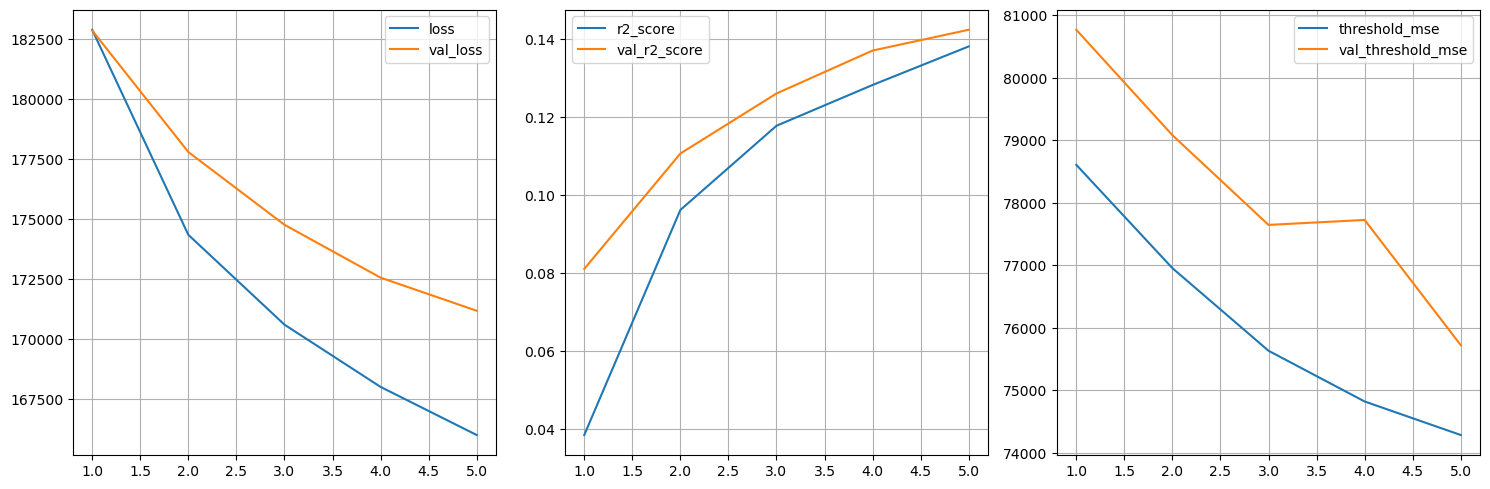

4395/4395 [==============================] - 46s 10ms/step - loss: 166005.7969 - r2_score: 0.1382 - threshold_mse: 74283.0234 - val_loss: 171180.8750 - val_r2_score: 0.1425 - val_threshold_mse: 75721.1250
Epoch 6/20
2143/4395 [=============>................] - ETA: 21s - loss: 163924.6562 - r2_score: 0.1452 - threshold_mse: 72652.1875

In [ ]:
start=time.time()

history = model.fit(X_train, y_train, batch_size = 1024, epochs=20, 
                    validation_data=(X_val, y_val), 
                    verbose=1, 
                    callbacks=callbacks
                   )

stop=time.time()

In [ ]:
print(f"Took {round(stop-start, 2)}s to run. ")

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    
def plot_history(history):
    plt.figure(figsize=(10, 7))
    plt.subplot(1, 2, 1)
    plot_graphs(history, 'loss')
    #plt.ylim(None, 1)
    plt.subplot(1, 2, 2)
    plot_graphs(history, 'r_square')
    #plt.ylim(0, None)
    plt.show()

In [ ]:
plot_history(history)

### Keras Tuner

Keras Tuner is the same idea as GridSearch, but in this case it is to try different NN designs to determine which one would be the best. 

In [27]:
%%capture capt
!pip install keras-tuner --upgrade

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [29]:
def build_model(hp):
    model = keras.Sequential()

    # 1. 1st Conv2D layer
    if hp.Boolean("kernelRegularizer"):
        model.add(layers.Conv2D(hp.Int('conv1_units', min_value=32, max_value=1024, step=32),
                                kernel_size=(3, 3),
                                activation='relu',
                                kernel_regularizer=regularizers.l2(0.01),
                                input_shape=(8, 8, NB_OHE)))
    else:
        model.add(layers.Conv2D(hp.Int('conv1_units', min_value=32, max_value=1024, step=32),
                                kernel_size=(3, 3),
                                activation='relu',
                                input_shape=(8, 8, NB_OHE)))

    # 2.  MaxPool layer
    model.add(layers.MaxPooling2D((2, 2)))

    # 3.  2nd Conv2D layer
    model.add(layers.Conv2D(hp.Int('conv2_units', min_value=32, max_value=256, step=32),
                            kernel_size=(3, 3),
                            activation='relu'))

    # 4.  Flatten layer
    model.add(layers.Flatten())

    # 5. BatchNormalization layer
    if hp.Boolean("batchNormalization1"):
        model.add(layers.BatchNormalization())

    # 6. Dropout layer
    if hp.Boolean("dropout1"):
        dropout_rate = hp.Float("dropout_rate1", min_value=0.2, max_value=0.5, step = 0.1)
        model.add(layers.Dropout(rate=dropout_rate))

    # 7. 1st Dense layer
    model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int("units_dense1", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation_dense1", ["elu", "selu", "relu"]),
            )
        )

    # 7. 2nd Dropout layer
    if hp.Boolean("dropout2"):
        dropout_rate = hp.Float("dropout_rate2", min_value=0.1, max_value=0.3, step = 0.1)
        model.add(layers.Dropout(rate=dropout_rate))

    # 8. 2nd BatchNormalization layer
    if hp.Boolean("batchNormalization2"):
        model.add(layers.BatchNormalization())
    
    # 9. Tune the number of dense layers
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_dense{i+1}", min_value=512, max_value=4096, step=128),
                activation=hp.Choice(f"activation_dense{i+1}", ["elu", "selu", "relu"]),
            )
        )

    # 10. 3rd Dropout layer
    if hp.Boolean("dropout3"):
        dropout_rate = hp.Float("dropout_rate3", min_value=0.2, max_value=0.4, step = 0.1)
        model.add(layers.Dropout(rate=dropout_rate))

    # 11. 3rd BatchNormalization layer
    if hp.Boolean("batchNormalization3"):
        model.add(layers.BatchNormalization())         

    # 12. Output layer
    model.add(layers.Dense(1))

    if hp.Boolean("lr_decay"):
        initial_learning_rate = 1e-2
        decay_steps = 1000
        decay_rate = 0.9
        # Define the learning rate schedule
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate, decay_steps, decay_rate)
    else:
        lr_schedule = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")
        
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[RSquare()],
    )
    return model

In [30]:
tuner = RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    #max_trials=5,
    executions_per_trial=2,
    overwrite=True,
    directory="prediction_models",
    project_name="tuner_search_chess",
)

In [ ]:
tuner.search_space_summary()

In [32]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, verbose=1)
callbacks = [es]

In [ ]:
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=callbacks)